# The LinearAntisymmetricCell user guide - part 1

This is an introduction guide on how to use the Linear Antisymmetric RNN cells described in Moe et al. 2020: http://proceedings.mlr.press/v120/moe20a/moe20a.pdf.


NB! The LARNN implementation works best with the `uniform` initializer for the recurrent kernel `W`. The `orthogonal` initializer yields unstable performance of the `forward` and `backward` methods.


In [1]:
import tensorflow as tf
import numpy as np

from larnn import LinearAntisymmetricCell
from larnn import utils

import matplotlib.pyplot as plt

%matplotlib notebook

## Example data
As an example, we consider the problem where we want to predict the next value of a time series $y(t+1)$, where $y$ is a function of some input signal $x$. Here $y(t)=-0.7y(t-1) + 10x(t)\sqrt{|x(t)|}$. The signal is sampeled at rate `delta`.

In [2]:
delta = 0.1
t_end = 350
t = np.arange(0, t_end, delta)

y_signal = np.zeros(t.shape)
x_signal = 0.05*np.sqrt(t)*np.sin(0.3*t)
prev = 0.0
for i in range(0,len(t)):
    y_signal[i] = 10*x_signal[i]*np.sqrt(np.abs(x_signal[i])) + prev
    prev += -0.7*y_signal[i]
x_signal = x_signal.reshape([x_signal.shape[0], 1])
y_signal = y_signal.reshape([x_signal.shape[0], 1])


<IPython.core.display.Javascript object>


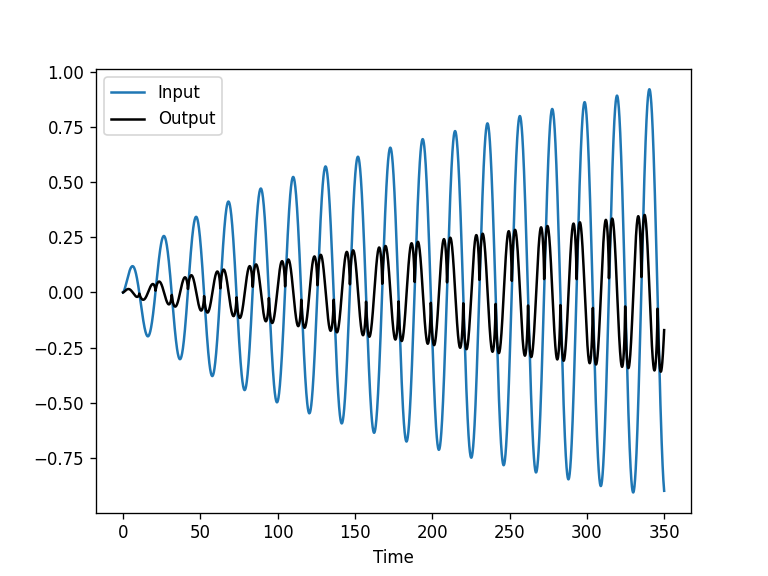

In [3]:
plt.figure()
plt.plot(t, x_signal, label = 'Input')
plt.plot(t, y_signal, label = 'Output', color = 'k')
plt.legend()
plt.xlabel('Time')
plt.show()

## Data preparation
We shape the data in the rolling window fashion as we usually do for timeseries forecasting.

The data matrix should be of shape `(nsamples, steps, features)`.

The ground truth matrix is of shape `(nsamples, 1)` as we are prediting only one value.

The `steps` parameter sets an upper limit on the RNN memory.

In [4]:
steps = 5
batch_size = 6
train_test_ratio = 0.8
step_size = 0.1

rollx, rolly = utils.rolling_window(x_signal, y_signal, steps)

(trainx, trainy), (testx, testy) = utils.split_data(rollx, rolly, batch_size, train_test_ratio) 

input_dim = trainx.shape[-1]

## Making the model

We make a RNN with `units` `LinearAntisymmetricCell`s using a functional model. A dense layer is added to make only one prediction. By default, the `LinearAntisymmetricCell` uses the implicit midpoint rule as a solver. A full description of the constructor parameters is given in the source file.

In [5]:
rnn_units = [16, 8]
lr = 0.1

opt = tf.keras.optimizers.Adam(lr)

model_input = tf.keras.Input(shape=(steps, input_dim), batch_size=None)

LARNN_cells_1 = LinearAntisymmetricCell(rnn_units[0], step_size=step_size)
rnn_layer_1 = tf.keras.layers.RNN(LARNN_cells_1, input_shape=(steps, input_dim), return_sequences=True)
LARNN_cells_2 = LinearAntisymmetricCell(rnn_units[1], step_size=step_size)
rnn_layer_2 = tf.keras.layers.RNN(LARNN_cells_2, input_shape=(steps, input_dim))
dense_layer = tf.keras.layers.Dense(1, activation="linear")

rnn_output_1 = rnn_layer_1(model_input)
rnn_output_2 = rnn_layer_2(rnn_output_1)
dense_output = dense_layer(rnn_output_2)

model = tf.keras.models.Model(model_input, dense_output)

model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
rnn (RNN)                    (None, 5, 16)             288       
_________________________________________________________________
rnn_1 (RNN)                  (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


## Training a model and making predictions

Training and prediction can be done like any other tf/keras model.

In [6]:
epochs = 20

model.fit(x=trainx, y=trainy, batch_size=batch_size, verbose=1, epochs=epochs)


Train on 2796 samples
Epoch 1/20
2796/2796 [==============================] - 4s 2ms/sample - loss: 0.0232
Epoch 2/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 0.0221
Epoch 3/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 0.0136
Epoch 4/20
2796/2796 [==============================] - 3s 985us/sample - loss: 0.0046
Epoch 5/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 7.6011e-04
Epoch 6/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 8.4558e-04
Epoch 7/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 0.0062
Epoch 8/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 9.9534e-04
Epoch 9/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 7.9908e-04
Epoch 10/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 0.0023
Epoch 11/20
2796/2796 [==============================] - 3s 1ms/sample - loss: 5.6706e-04
Epoch 12/20
2796/27

<IPython.core.display.Javascript object>


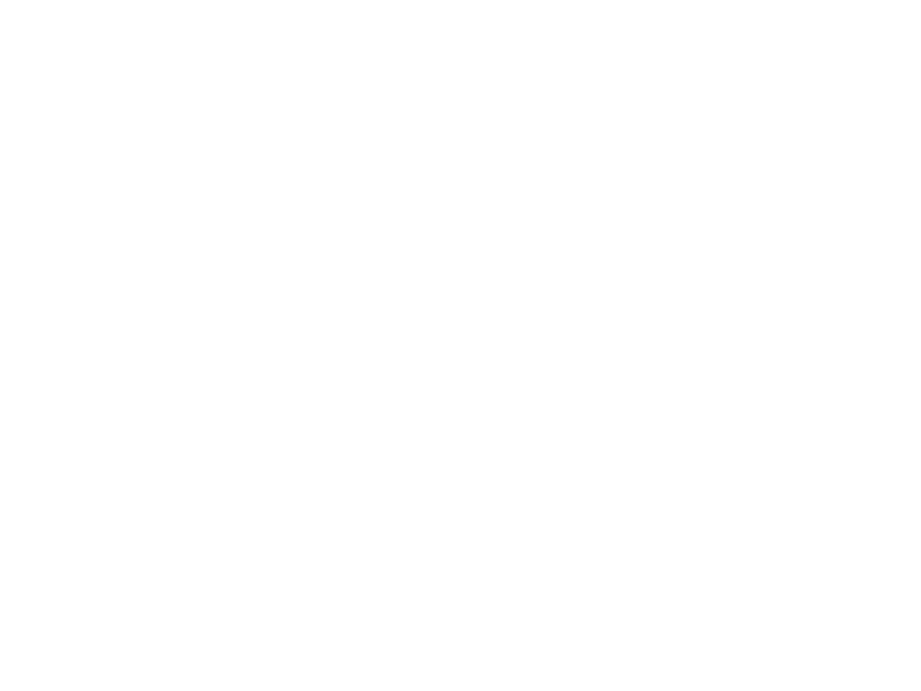

Test error
------------
Mean squared error: 1.0484097728047121


In [7]:
trainpreds = model.predict(trainx)
preds = model.predict(testx)

traint = t[:trainx.shape[0]]
testt = t[trainx.shape[0]:(trainx.shape[0] + testx.shape[0])]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(x=traint[-1], color='black')
ax.plot(traint, trainy, label='Ground truth', color='green')
ax.plot(traint, trainpreds, label=r'Training predictions', color='blue')
ax.plot(testt, testy, color='green')
ax.plot(testt, preds, label=r'Test predictions', color='orange')
ax.legend()

print('Test error\n------------')
print(f'Mean squared error: {np.mean(np.linalg.norm(preds - testy))}')